# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code). Here, we will implement the preprocessing for the *handcrafted state-space approach* as used by [Roggeveen et al.](https://www.sciencedirect.com/science/article/pii/S0933365720312689), by aggregating measurements into bins of 4 hours starting from the 24 hour prior to sepsis onset to 48 hours after (72 hours in total).

The original notebook was written in R; I have reimplemented the preprocessing in Python and validated this reimplementation with the original notebook (minus small errors made in the original which I corrected, see `Note:` remarks).

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import re

from datetime import timedelta
from tqdm import tqdm

DATA_DIR = '../data/mimic-iii/final/'

### Convenience functions

In [3]:
# Read CSV from file and parse dates using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    # Explicit as parse_dates param of pd.read_csv fails to identify starttime and endtime
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

# Plots values of under `key` over time
def plot_single(dct, key, title='', xlabel='Timestep', ylabel='Value'):
    # Find icustay_id of ICU stay with measurrement for key
    icustay_id = None
    no_data = True
    while no_data:
        icustay_id = random.choice(list(set(dct.keys())))
        no_data = not key in dct[icustay_id].keys()
        
    plt.figure(figsize=(8, 3))
    plt.plot(dct[icustay_id][key])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Converts TimeDelta objects into hours
def to_hours(x):
    return x.astype('timedelta64[s]').astype(int) / 3600

# Converts upper- or camelcase to snake-case (lowercase with '_' separators)
def to_snakecase(string):
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()
    
print('HeartRate => %s' % to_snakecase('HeartRate'))
print('ALBUMIN   => %s' % to_snakecase('ALBUMIN'))
print('FiO2      => %s' % to_snakecase('FiO2'))
print('MeanBP    => %s' % to_snakecase('MeanBP'))
print('timestep  => %s' % to_snakecase('timestep'))

HeartRate => heart_rate
ALBUMIN   => albumin
FiO2      => fi_o2
MeanBP    => mean_bp
timestep  => timestep


---
## Patient Cohort (`cohort.csv`)

Using MIMIC-Code we have extracted a *sepsis-3* cohort (i.e. a list of patients satisfying the sepsis-3 criteria) along with information regarding the suspected time of infection and in-hospital mortality, `hospital_expire_flag`. Let's first import these data;

In [4]:
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
cohort_df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,10006,142345,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 15:30:00,2164-10-22 15:30:00,2164-10-25 15:30:00,0
1,10013,165520,264446,2125-10-04 23:38:00,2125-10-07 15:13:52,2125-10-05 02:00:00,2125-10-04 02:00:00,2125-10-07 02:00:00,1
2,10017,199207,204881,2149-05-29 18:52:29,2149-05-31 22:19:17,2149-05-27 05:15:00,2149-05-26 05:15:00,2149-05-29 05:15:00,0
3,10019,177759,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,2163-05-14 21:52:00,2163-05-13 21:52:00,2163-05-16 21:52:00,1
4,10026,103770,277021,2195-05-17 07:40:18,2195-05-19 17:24:25,2195-05-17 09:12:00,2195-05-16 09:12:00,2195-05-19 09:12:00,0


### Limit Admissions to SOFA $\geq$ 2

In [5]:
# Determine patients with SOFA > 2
# Note: Although the original uses SOFA>3, the paper mentions the standard SOFA>=2 as the selection criterion
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')
sofa3_icustays = set([row['icustay_id'] for _, row in demo_df.iterrows() if row['sofa'] >= 2])

# Filter cohort
cohort_df = cohort_df[cohort_df['icustay_id'].isin(sofa3_icustays)]

In [6]:
icustay_ids = cohort_df['icustay_id'].values
print('Number of ICU-stays: %s' % icustay_ids.size)

Number of ICU-stays: 60


We will collect features in a dict `data_all`, mapping from each icustay to the corresponding time series data of each measurement type (e.g. `heartrate`, `sysbp`, `total_iv_fluid`, `wbc`);

In [7]:
# We will store our data in this
data_all = {icustay_id:dict() for icustay_id in cohort_df['icustay_id'].values}

# See? empty...
assert data_all[210989] == {}

---

## Timesteps of 4 Hours

First, for each 72-hour time window (spanning 24h prior to sepsis onset to 48h after) we will precompute all intermediate timesteps in increments of 4 hours. Each time we add our output to `data_all`;

In [8]:
def date_range(icustay, freq='4H'):
    starttime = icustay['window_start']
    endtime = icustay['window_end']
    return pd.date_range(start=starttime, end=endtime, freq=freq).values
    
icustay_timesteps = {icustay['icustay_id']: date_range(icustay) for _, icustay in cohort_df.iterrows()}

Add timesteps for each ICU stay to `data_all`;

In [9]:
for icustay_id, timesteps in icustay_timesteps.items():
    data_all[icustay_id]['timestep'] = timesteps

In [10]:
# Plot timesteps of random patient
icustay_id = random.choice(list(set(data_all.keys())))
data_all[icustay_id]

{'timestep': array(['2170-12-14T00:00:00.000000000', '2170-12-14T04:00:00.000000000',
        '2170-12-14T08:00:00.000000000', '2170-12-14T12:00:00.000000000',
        '2170-12-14T16:00:00.000000000', '2170-12-14T20:00:00.000000000',
        '2170-12-15T00:00:00.000000000', '2170-12-15T04:00:00.000000000',
        '2170-12-15T08:00:00.000000000', '2170-12-15T12:00:00.000000000',
        '2170-12-15T16:00:00.000000000', '2170-12-15T20:00:00.000000000',
        '2170-12-16T00:00:00.000000000', '2170-12-16T04:00:00.000000000',
        '2170-12-16T08:00:00.000000000', '2170-12-16T12:00:00.000000000',
        '2170-12-16T16:00:00.000000000', '2170-12-16T20:00:00.000000000',
        '2170-12-17T00:00:00.000000000'], dtype='datetime64[ns]')}

---
## Vasopressors

#### 1. MetaVision (`vasopressors_mv_cohort.csv`)

In [11]:
vaso_mv_df = read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,orderid,linkorderid,vasoactive_drug,mcgkgmin,mcgmin
0,210989,2144-07-13 11:15:00,2144-07-13 11:30:00,8.013029,mcg/kg/min,81.7,3675533,3675533,dopamine,0.080130,6.546645
1,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,10.012087,mcg/kg/min,81.7,3991678,3675533,dopamine,0.100121,8.179875
2,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,0.502150,mcg/kg/min,81.7,223781,223781,norepinephrine,0.502150,41.025643
3,210989,2144-07-13 11:50:00,2144-07-13 11:55:00,0.251075,mcg/kg/min,81.7,7456868,223781,norepinephrine,0.251075,20.512822
4,210989,2144-07-13 11:55:00,2144-07-13 19:06:00,0.200979,mcg/kg/min,81.7,8100615,223781,norepinephrine,0.200979,16.419956


In [12]:
# Consider ICU stays one-by-one
for icustay_id, treatments in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Is patient part of cohort?
    if icustay_id not in data_all:
        continue
        
    # Populate empty vector of measurements
    timesteps = icustay_timesteps[icustay_id]
    max_vaso = np.zeros(len(timesteps) - 1, dtype=np.float64)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: treatment time overlaps with current interval.
        # NOTE: original R-code erroneously used 'endtime < interval_end'
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        
        # Compute max vasopressor intake in mcg/kg/min (norepinephrine-equivalent)
        # Q - What is rationale for max?
        max_vaso[i] = np.nan_to_num(treatments[condition]['mcgkgmin'].max(), nan=0)
        
    data_all[icustay_id]['max_vaso'] = max_vaso

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.20it/s]


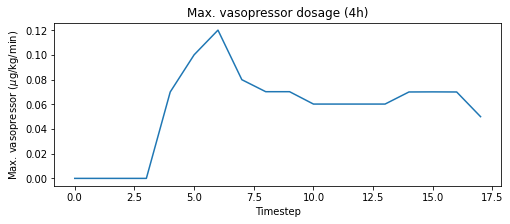

In [14]:
# Plot random patient
plot_single(data_all, key='max_vaso', title='Max. vasopressor dosage (4h)', ylabel='Max. vasopressor ($\mu$g/kg/min)')

---
## IV Fluids

#### 1. MetaVision (`inputevents_mv_cohort.csv`)

In [15]:
ivfluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (ivfluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (ivfluid_mv_df['amountuom'] == 'ml')
ivfluid_mv_df = ivfluid_mv_df[condition]

# Sanity check: remove amounts outside (0, 5000) range
ivfluid_mv_df = ivfluid_mv_df[(ivfluid_mv_df['amount'] > 0) & (ivfluid_mv_df['amount'] < 5000)]

# Compute duration in hours
# NOTE: original erroneously measured time in minutes
ivfluid_mv_df['duration'] = to_hours(ivfluid_mv_df['endtime'] - ivfluid_mv_df['starttime'])

# Drop unused columns
ivfluid_mv_df = ivfluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]
ivfluid_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
1,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:07:00,999.999978,7.766667
2,40124,126179,279554,2130-02-04 12:36:00,2130-02-04 18:39:00,907.500000,6.050000
4,40124,126179,279554,2130-02-04 14:46:00,2130-02-05 09:01:00,164.299998,18.250000
5,40124,126179,279554,2130-02-05 11:06:00,2130-02-05 15:06:00,499.999992,4.000000
7,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:21:00,999.999984,8.000000


In order to determine the total amount of IV fluid administered within each 4 hour interval, we use the `total_admin_in_interval` function:

In [16]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments['starttime']
    dose_end = treatments['endtime']
    amount = treatments['amount']
    duration = treatments['duration']
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()
    
    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (interval_end < dose_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    return total_ml

We can now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatment in `ivfluid_mv_df` to compute the total IV fluid administration within each 4 hour interval:

In [17]:
print('Grab some coffee!')

for icustay_id, treatments in tqdm(ivfluid_mv_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
    
    # Total fluid intake
    timesteps = icustay_timesteps[icustay_id]
    total_ivfluid = np.zeros(len(timesteps) - 1, dtype=np.float64)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Compute total IV fluid
        total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
        
    # Save!
    data_all[icustay_id]['total_iv_fluid'] = total_ivfluid

Grab some coffee!


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.06it/s]


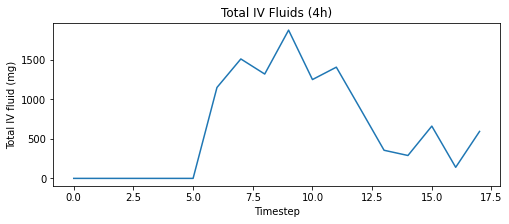

In [20]:
# Grab IV fluids from random patient
plot_single(data_all, key='total_iv_fluid', title='Total IV Fluids (4h)', ylabel='Total IV fluid (mg)')

#### Adding IV Fluid Running Total

In Roggeveen et al. an additional feature is incorporated which measures the total IC fluid administered up to the curren timestep. We implement this here using `np.cumsum`;

In [21]:
for icustay_id, icustay_data in data_all.items():
    if 'total_iv_fluid' in icustay_data.keys():
        data_all[icustay_id]['running_total_iv_fluid'] = np.cumsum(icustay_data['total_iv_fluid'])

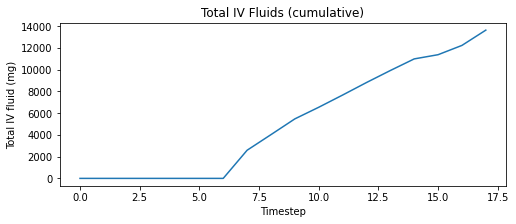

In [22]:
# Grab IV fluids from random patient
plot_single(data_all, key='running_total_iv_fluid', title='Total IV Fluids (cumulative)', ylabel='Total IV fluid (mg)')

---
## Vital functions (`vitals_cohort.csv`)

In [23]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')
vitals_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,DiasBP,50.000000
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,HeartRate,104.000000
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,MeanBP,63.666698
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,RespRate,25.000000
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,SpO2,98.000000


In [24]:
# Vitals recorded
ALL_VITALS = list(set(vitals_df['vital_id']))
print(ALL_VITALS)

['SpO2', 'MeanBP', 'HeartRate', 'RespRate', 'Glucose', 'TempC', 'SysBP', 'DiasBP']


In [25]:
print('Snake-case vitals:')
print([to_snakecase(x) for x in ALL_VITALS])

Snake-case vitals:
['sp_o2', 'mean_bp', 'heart_rate', 'resp_rate', 'glucose', 'temp_c', 'sys_bp', 'dias_bp']


<br>
Binning measurements into intervals of 4 hours:

In [26]:
for icustay_id, measurements in tqdm(vitals_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add keys for each vital_id to data_all with empty measurements vector
    timesteps = icustay_timesteps[icustay_id]
    for vital_id in ALL_VITALS:
        data_all[icustay_id][to_snakecase(vital_id)] = np.zeros(len(timesteps) - 1, dtype=np.float32)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: Measurement `charttime` in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] < interval_end)  
        
        # Compute average value of each vital_id
        vital_means = measurements[condition].groupby('vital_id')['valuenum'].mean()
        
        for vital_id, value in vital_means.items():
            data_all[icustay_id][to_snakecase(vital_id)][i] = value

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 38.70it/s]


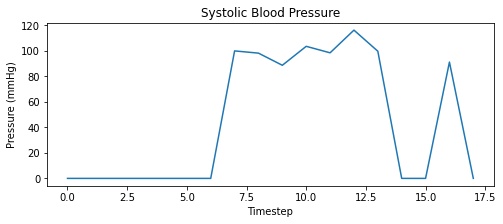

In [27]:
# Grab SysBP from random patient
plot_single(data_all, key='sys_bp', title='Systolic Blood Pressure', ylabel='Pressure (mmHg)')

---
## Lab results (`labs_cohort.csv`)

In [28]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')

# Drop rows with NaNs
lab_df = lab_df.dropna(axis=0)

lab_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,lab_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:33:00,LACTATE,4.4
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALAT,9.0
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALBUMIN,3.4
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ANION GAP,20.0
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ASAT,40.0


In [29]:
# Which hormones / fluids were measured?
ALL_LAB_IDS = list(set(lab_df['lab_id'].values))
print(ALL_LAB_IDS) 

['PAO2', 'GLUCOSE', 'MAGNESIUM', 'ASAT', 'PACO2', 'ALAT', 'SODIUM', 'ALBUMIN', 'POTASSIUM', 'BaseExcess', 'BILIRUBIN', 'BICARBONATE', 'PT', 'PTT', 'BUN', 'CALCIUM', 'PLATELET', 'BANDS', 'LACTATE', 'CREATININE', 'WBC', 'ANION GAP', 'PH', 'CHLORIDE', 'HEMOGLOBIN', 'ION_CALCIUM']


In [30]:
print('Snake-case lab_ids:')
print([to_snakecase(x) for x in ALL_LAB_IDS])

Snake-case lab_ids:
['pao2', 'glucose', 'magnesium', 'asat', 'paco2', 'alat', 'sodium', 'albumin', 'potassium', 'base_excess', 'bilirubin', 'bicarbonate', 'pt', 'ptt', 'bun', 'calcium', 'platelet', 'bands', 'lactate', 'creatinine', 'wbc', 'anion gap', 'ph', 'chloride', 'hemoglobin', 'ion_calcium']


<br>
Binning into intervals of 4 hours;

In [31]:
for icustay_id, lab_results in tqdm(lab_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    for lab_id in ALL_LAB_IDS:
        data_all[icustay_id][to_snakecase(lab_id)] = np.zeros(len(timesteps) - 1, dtype=np.float32)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: Measurement charttime in (interval_start, interval_end)
        condition = (lab_results['charttime'] > interval_start) & (lab_results['charttime'] <= interval_end)  
        
        # Compute average value of each lab_id
        lab_means = lab_results[condition].groupby('lab_id')['valuenum'].mean()
        
        for item_id, value in lab_means.items():
            data_all[icustay_id][to_snakecase(item_id)][i] = value

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 39.28it/s]


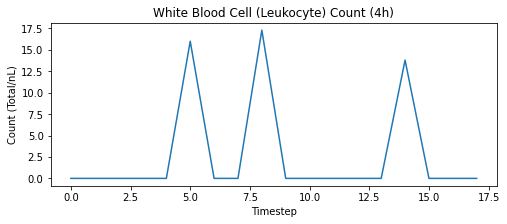

In [32]:
# Grab Leukocyte count from random patient
plot_single(data_all, key='wbc', title='White Blood Cell (Leukocyte) Count (4h)', ylabel='Count (Total/nL)')

---
## Urine Output (`urineoutput_cohort.csv`)

In [33]:
urine_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

# Sanity check: drop values exceeding 5000
urine_df = urine_df[(urine_df['value'] > 0) & (urine_df['value'] < 5000)]

urine_df.head()

,subject_id,hadm_id,icustay_id,charttime,value
0,42321,114648,201204,2121-12-08 17:00:00,40
1,42321,114648,201204,2121-12-08 22:00:00,40
2,42321,114648,201204,2121-12-09 07:00:00,25
3,42321,114648,201204,2121-12-07 22:00:00,30
4,42321,114648,201204,2121-12-08 00:12:00,30


In [34]:
for icustay_id, measurements in tqdm(urine_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    data_all[icustay_id]['total_urine_output'] = np.zeros(len(timesteps) - 1, dtype=np.float32)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: Measurement charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)  
        
        # Compute average value of each vital_id
        data_all[icustay_id]['total_urine_output'][i] = measurements[condition]['value'].sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 72.15it/s]


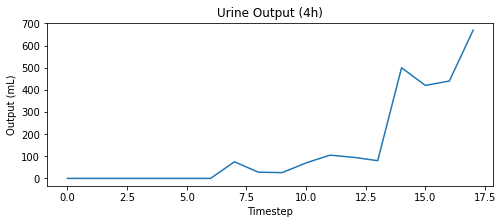

In [35]:
# Grab urine output from random patient
plot_single(data_all, key='total_urine_output', title='Urine Output (4h)', ylabel='Output (mL)')

#### Running Total Urine Output

In Roggeveen et al. an additional feature `running_total_urine_output` is included into the feature set; we add this feature here using `np.cumsum`;

In [36]:
for icustay_id, icustay_data in data_all.items():
    if 'total_urine_output' in icustay_data.keys():
        data_all[icustay_id]['running_total_urine_output'] = np.cumsum(icustay_data['total_urine_output'])

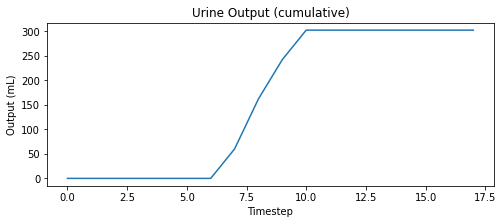

In [37]:
# Grab urine output from random patient
plot_single(data_all, key='running_total_urine_output', title='Urine Output (cumulative)', ylabel='Output (mL)')

---
## FiO2 (Fraction of Inspired Oxygen) (`fio2_cohort.csv`)

In [38]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')
fio2_df.head()

,subject_id,hadm_id,icustay_id,charttime,fio2
0,10013,165520,264446,2125-10-05 00:00:00,60.000002
1,10013,165520,264446,2125-10-05 01:00:00,40.000001
2,10013,165520,264446,2125-10-05 03:00:00,40.000001
3,10013,165520,264446,2125-10-05 07:00:00,69.999999
4,10013,165520,264446,2125-10-05 10:00:00,69.999999


In [43]:
# Process ICU stays one-by-one
for icustay_id, measurements in tqdm(fio2_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    data_all[icustay_id]['fi_o2'] = np.zeros(len(timesteps) - 1, dtype=np.float32)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: Measurement charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)  
        
        # Compute average value of each vital_id
        data_all[icustay_id]['fi_o2'][i] = measurements[condition]['fio2'].mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 67.24it/s]


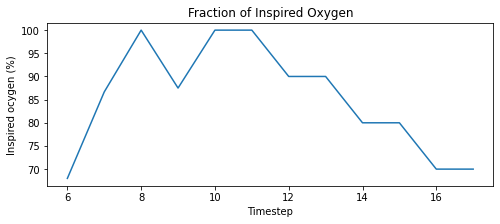

In [48]:
# Grab FiO2 from random patient
plot_single(data_all, key='fi_o2', title='Fraction of Inspired Oxygen', ylabel='Inspired ocygen (%)')

---
## Demographics (`demographics_cohort.csv`)

In [49]:
demo_df = pd.read_csv(DATA_DIR + 'demographics_cohort.csv')
demo_df.head()

,subject_id,hadm_id,icustay_id,age,is_male,race_white,race_black,race_hispanic,race_other,height,...,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive
0,10006,142345,206504,70.6354,0,0,1,0,0,NaN,...,0,6,6,2,2,1,0,1,5,1
1,10013,165520,264446,87.0847,0,0,0,0,1,165.10,...,1,7,5,4,2,1,0,1,8,0
2,10017,199207,204881,73.6772,0,1,0,0,0,NaN,...,0,2,0,4,2,1,0,1,-1,0
3,10019,177759,228977,48.8991,1,1,0,0,0,180.34,...,1,19,13,4,2,1,0,1,0,1
4,10026,103770,277021,91.4000,0,1,0,0,0,NaN,...,0,2,2,2,2,0,1,1,1,1


In [50]:
# Define demographics and disease severity scores of interest (on admission)
DEMOGRAPHICS_COLS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [51]:
for icustay_id, demographics in tqdm(demo_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    timesteps = icustay_timesteps[icustay_id]
    N = len(timesteps) - 1
    
    for feature in DEMOGRAPHICS_COLS:
        data_all[icustay_id][feature] = np.ones(N) * demographics[feature].values[0]

100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 3416.90it/s]


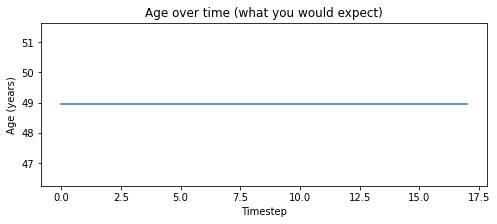

In [54]:
plot_single(data_all, key='age', title='Age over time (what you would expect)', ylabel='Age (years)')

---
# Final Processing

## Add Reward
We define positive terminal reward (R=15) as discharge of patient (survival beyond hospital stay) and negative reward (R=-15) by in-hospital mortality (i.e. did the patient pass away during ICU admission). No intermediate rewards are issued.

In [55]:
# Dict mapping from patient to 30-day mortality
mortality_dct = {row['icustay_id']:row['hospital_expire_flag'] for _, row in cohort_df.iterrows()}

# Process ICU stays one-by-one
for icustay_id, patient in tqdm(cohort_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Determine whether person passed away in hospital
    timesteps = icustay_timesteps[icustay_id]
    deceased = mortality_dct[icustay_id]
    
    # Define reward as +15 if survived; -15 otherwise; no intermediate rewards
    rewards = np.zeros(len(timesteps) - 1)
    rewards[-1] = 15 if not deceased else -15
    
    data_all[icustay_id]['reward'] = rewards

100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 20017.36it/s]


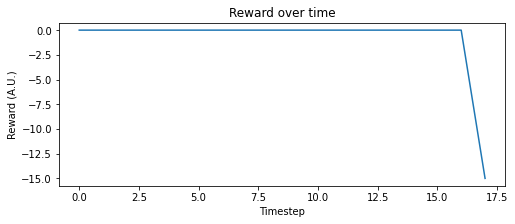

In [59]:
# Grab Reward trajectory from random patient
plot_single(data_all, key='reward', title='Reward over time', ylabel='Reward (A.U.)')

## Shift Actions in Time by One Timestep

In [60]:
for icustay_id, icustay_data in data_all.items():
    
    # Shift actions and reward sequence forward by one
    if 'total_iv_fluid' in data_all[icustay_id]:
        data_all[icustay_id]['total_iv_fluid_shifted'] = list(data_all[icustay_id]['total_iv_fluid'][1:]) + [np.NaN]
        
    if 'max_vaso' in data_all[icustay_id]:
        data_all[icustay_id]['max_vaso_shifted'] = list(data_all[icustay_id]['max_vaso'][1:]) + [np.NaN]
        
    if 'reward' in data_all[icustay_id]:
        data_all[icustay_id]['reward_shifted'] = list(data_all[icustay_id]['reward'][1:]) + [np.NaN]
        
print('Done!')

Done!


## Convert to DataFrame!

In [61]:
# Mark measurement by interval_end (drop interval_start)
num_samples = 72 // 4
for icustay_id in data_all.keys():
    data_all[icustay_id]['timestep'] = data_all[icustay_id]['timestep'][:num_samples]

# Convert subdicts to DataFrames
data_all_df = {icustay_id: pd.DataFrame.from_dict(icustay_data) for icustay_id, icustay_data in data_all.items()}

# Add icustay_id as identifier
for icustay_id in data_all_df.keys():
    data_all_df[icustay_id]['icustay_id'] = icustay_id
    
# Merge into one large DataFrame
data_all_df = pd.concat(data_all_df.values()).reset_index()
data_all_df.head()

,index,timestep,sp_o2,mean_bp,heart_rate,resp_rate,glucose,temp_c,sys_bp,dias_bp,...,sirs,reward,reward_shifted,icustay_id,fi_o2,total_iv_fluid,running_total_iv_fluid,total_iv_fluid_shifted,max_vaso,max_vaso_shifted
0,0,2164-10-22 15:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,206504,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2164-10-22 19:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,206504,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2164-10-22 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,206504,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2164-10-23 03:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,206504,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2164-10-23 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,206504,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Casefold column names
data_final_df = pd.DataFrame({'icustay_id': data_all_df['icustay_id'], 
                              'timestep': data_all_df['timestep'], 
                              # Discretized action added below
                              'max_vp': data_all_df['max_vaso'],
                              'max_vp_shifted': data_all_df['max_vaso_shifted'],
                              'total_iv_fluid': data_all_df['total_iv_fluid'],
                              'total_iv_fluid_shifted': data_all_df['total_iv_fluid_shifted'],
                              'reward': data_all_df['reward_shifted'],
                              'sirs_score': data_all_df['sirs'],
                              'sofa_score': data_all_df['sofa'],
                              'weight': data_all_df['weight'],
                              'ventilator': data_all_df['vent'],
                              'height': data_all_df['height'],
                              'age': data_all_df['age'],
                              'gender': data_all_df['is_male'],
                              'heart_rate': data_all_df['heart_rate'],
                              'temp': data_all_df['temp_c'],
                              'mean_bp': data_all_df['mean_bp'],
                              'dias_bp': data_all_df['dias_bp'],
                              'sys_bp': data_all_df['sys_bp'],
                              'resp_rate': data_all_df['resp_rate'],
                              'spo2': data_all_df['sp_o2'],
                              'natrium': data_all_df['sodium'],
                              'chloride': data_all_df['chloride'],
                              'kalium': data_all_df['potassium'],
                              'trombo': data_all_df['platelet'],
                              'leu': data_all_df['wbc'],
                              'anion_gap': data_all_df['anion gap'],
                              'aptt': data_all_df['ptt'],
                              'art_ph': data_all_df['ph'],
                              'asat': data_all_df['asat'],
                              'alat': data_all_df['alat'],
                              'bicarbonaat': data_all_df['bicarbonate'],
                              'art_be': data_all_df['base_excess'],
                              'ion_ca': data_all_df['ion_calcium'],
                              'lactate': data_all_df['lactate'],
                              'paco2': data_all_df['paco2'],
                              'pao2': data_all_df['pao2'],
                              'shock_index': data_all_df['heart_rate'] / data_all_df['sys_bp'],
                              'hb': data_all_df['hemoglobin'] * 0.6206,
                              'bilirubin': data_all_df['bilirubin'] * (1 / 0.05847953),
                              'creatinine': data_all_df['creatinine'] * (1 / 0.01131222),
                              'inr': data_all_df['pt'] / 12,
                              'ureum': data_all_df['bun'] * 0.3571,
                              'albumin': data_all_df['albumin'] * 10,
                              'magnesium': data_all_df['magnesium'] * 0.411,
                              'calcium': data_all_df['calcium'] * 0.25,
                              'pf_ratio': data_all_df['paco2'] / data_all_df['fi_o2'],
                              'glucose': data_all_df['glucose'] * 0.0555,
                              'running_total_urine_output': data_all_df['running_total_urine_output'],
                              'total_urine_output': data_all_df['total_urine_output'],
                              'running_total_iv_fluid': data_all_df['running_total_iv_fluid'],})
data_final_df.head()

,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,inr,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid
0,206504,2164-10-22 15:30:00,NaN,NaN,NaN,NaN,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
1,206504,2164-10-22 19:30:00,NaN,NaN,NaN,NaN,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
2,206504,2164-10-22 23:30:00,NaN,NaN,NaN,NaN,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
3,206504,2164-10-23 03:30:00,NaN,NaN,NaN,NaN,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
4,206504,2164-10-23 07:30:00,NaN,NaN,NaN,NaN,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN


In [104]:
# Grab data from random patient
icustay_id = random.choice(list(set(data_all.keys())))
data_final_df[data_final_df['icustay_id'] == icustay_id]

,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,inr,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid
1044,239396,2123-11-23 14:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.0000,0.0,0.0,0.000000
1045,239396,2123-11-23 18:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.0000,0.0,0.0,0.000000
1046,239396,2123-11-23 22:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.0000,0.0,0.0,0.000000
1047,239396,2123-11-24 02:40:00,0.000000,0.000000,0.000000,0.000000,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.0000,0.0,0.0,0.000000
1048,239396,2123-11-24 06:40:00,0.000000,0.080030,0.000000,8.550914,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,NaN,0.0000,0.0,0.0,0.000000
1049,239396,2123-11-24 10:40:00,0.080030,0.120031,8.550914,1225.275694,0.0,3.0,18.0,NaN,...,1.866667,19.640501,29.0,0.9453,1.900,NaN,6.3825,0.0,0.0,8.550914
1050,239396,2123-11-24 14:40:00,0.120031,0.139902,1225.275694,860.840935,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,0.647059,0.0000,38.0,38.0,1233.826608
1051,239396,2123-11-24 18:40:00,0.139902,0.102976,860.840935,725.249963,0.0,3.0,18.0,NaN,...,0.000000,20.354700,0.0,1.0275,2.225,0.507692,5.4945,51.0,13.0,2094.667542
1052,239396,2123-11-24 22:40:00,0.102976,0.102976,725.249963,820.480229,0.0,3.0,18.0,NaN,...,0.000000,0.000000,0.0,0.0000,0.000,0.000000,0.0000,58.0,7.0,2819.917505
1053,239396,2123-11-25 02:40:00,0.102976,0.200460,820.480229,1938.179925,0.0,3.0,18.0,NaN,...,1.808333,17.140800,30.0,0.9042,2.075,0.685714,5.6055,62.0,4.0,3640.397734


## Discretize Action Space

In [105]:
# Compute 5-bin histogram to obtain discrete intervals
def get_quantile_intervals(vals):
    vals = vals[vals > 0]
    return [0] + [np.nanquantile(vals, i) for i in np.linspace(0, 1, 5)]

max_vp_bins = get_quantile_intervals(data_final_df['max_vp_shifted'].values)
tot_iv_bins = get_quantile_intervals(data_final_df['total_iv_fluid_shifted'].values)

print('Max. vasopressor bins:', max_vp_bins)
print('Intr. (IV) fluid bins:', tot_iv_bins)

Max. vasopressor bins: [0, 0.0494738031, 0.0799694817035, 0.1601278499, 0.24798583045, 1.413021719475]
Intr. (IV) fluid bins: [0, 2.4201356, 185.1616955598, 490.11735004, 941.21094273, 7224.1500181520005]


In [106]:
# Replace NaNs by zero (no vasopressor or IV fluid treatment, so dose = zero)
data_final_df['max_vp'] = data_final_df['max_vp'].fillna(0)
data_final_df['total_iv_fluid'] = data_final_df['total_iv_fluid'].fillna(0)
data_final_df['max_vp_shifted'] = data_final_df['max_vp_shifted'].fillna(0)
data_final_df['total_iv_fluid_shifted'] = data_final_df['total_iv_fluid_shifted'].fillna(0)

# Use pd.cut to discretize actions
max_vp_discrete = pd.cut(data_final_df['max_vp_shifted'], 
                         bins=max_vp_bins, 
                         labels=[0, 1, 2, 3, 4], 
                         include_lowest=True).astype(float)

total_iv_discrete = pd.cut(data_final_df['total_iv_fluid_shifted'], 
                           bins=tot_iv_bins, 
                           labels=[0, 1, 2, 3, 4], 
                           include_lowest=True).astype(float)

# Compute action as 5 * total_iv_fluid + max_vaso
data_final_df['discretized_action'] = 5 * total_iv_discrete + max_vp_discrete
data_final_df.head()

,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,discretized_action
0,206504,2164-10-22 15:30:00,0.0,0.0,0.0,0.0,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
1,206504,2164-10-22 19:30:00,0.0,0.0,0.0,0.0,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
2,206504,2164-10-22 23:30:00,0.0,0.0,0.0,0.0,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
3,206504,2164-10-23 03:30:00,0.0,0.0,0.0,0.0,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
4,206504,2164-10-23 07:30:00,0.0,0.0,0.0,0.0,0.0,2.0,6.0,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0


#### Export Action Bins

In [107]:
# Save bin edges of max_vaso and total_iv_fluid as .npy files for later reference
with open('max_vaso_bins.npy', 'w') as file:
    np.savetxt(file, max_vp_bins)
    
with open('total_iv_fluid_bins.npy', 'w') as file:
    np.savetxt(file, tot_iv_bins)
    
print('Done!')

Done!


#### Export Map from Actions to IV/Vaso Bins

In [108]:
# Save mapping from action indices (0 to 24) to bin indices (0 to 4)
bins_to_action_id = dict()
for max_vaso in range(5):
    for total_iv_fluid in range(5):
        bins_to_action_id[5 * total_iv_fluid + max_vaso] = (total_iv_fluid, max_vaso)

with open('action_to_vaso_fluid_bins.npy', 'w') as file:
    np.savetxt(file, tot_iv_bins)
print('Done!')

Done!


## Training, Validation and Test

To train and test the model we need dedicated training, validation (e.g. for hyperparameter tuning) and test sets. We perform the splitting below;

In [109]:
# Specify fraction of ICU-stays for training, validation and testing
frac_train = 0.7
frac_valid = 0.1

# Randomly assign icustay_ids to train, val and test
icustay_ids = list(set(data_final_df['icustay_id']))
random.shuffle(icustay_ids)

num_train = int(len(icustay_ids) * frac_train)
num_valid = int(len(icustay_ids) * frac_valid)

train_icustays = icustay_ids[:num_train]
valid_icustays = icustay_ids[num_train:num_train + num_valid]
test_icustays = icustay_ids[num_train + num_valid:]

print('Dataset instances:')
print('Train  %s' % len(train_icustays))
print('Valid  %s' % len(valid_icustays))
print('Test   %s' % len(test_icustays))

Dataset instances:
Train  42
Valid  6
Test   12


In [110]:
data_train_df = data_final_df[data_final_df['icustay_id'].isin(train_icustays)].reset_index(drop=True)
data_valid_df = data_final_df[data_final_df['icustay_id'].isin(valid_icustays)].reset_index(drop=True)
data_test_df = data_final_df[data_final_df['icustay_id'].isin(test_icustays)].reset_index(drop=True)
print('Done!')

Done!


## Feature Normalization
In order to work well with neurla networks we may wish to normlize the input and perform various kinds of transformations (e.g. log transforms). Here we follow Roggeveen et al. and perform the normalization and transformation using *clinically-guided feature engineering*;

In [111]:
BINARY_FIELDS = ['ventilator', 'gender']
LOG_FIELDS = ['max_vaso', 'spo2', 'ureum', 'creatinine', 'alat', 'asat', 'bilirubin', 'inr', 'running_total_iv_fluid',
              'total_iv_fluid', 'running_total_urine_output', 'total_urine_output']
EXCLUDE = ['icustay_id', 'timestep', 'reward', 'discretized_action']

### Z-scoring and Log-transforms

In [112]:
# Compute training set averages and stdevs
avgs, stds = dict(), dict()
for col in data_final_df.columns:
    if col not in EXCLUDE:
        avgs[col] = data_train_df[col].mean() # training set mean
        stds[col] = data_train_df[col].std()  # training set std

# Perform normalization with values from data_train_df
for df in [data_train_df, data_valid_df, data_test_df]:
    for col in df.columns:
        if col not in EXCLUDE:
            if col in BINARY_FIELDS:
                # Binary
                df[col] = df[col] - 0.5
            elif col in LOG_FIELDS:
                # Log
                df[col] = np.log(0.1 + df[col])
            else:
                # Linear
                df[col] = (df[col] - avgs[col]) / stds[col]
print('Done!')

### MinMax Normalization
After Z-scoring Roggeveen et al. scales all features using MinMax normalization, which we will repeat for good measure;

In [113]:
for col in df.columns:
    if col not in EXCLUDE:
        # Min/max estimates from training set!
        train_min = data_train_df[col].min()
        train_max = data_train_df[col].max()
        
        data_train_df[col] = (data_train_df[col] - train_min) / (train_max - train_min)
        data_valid_df[col] = (data_valid_df[col] - train_min) / (train_max - train_min)
        data_test_df[col] = (data_test_df[col] - train_min) / (train_max - train_min)
print('Done!')

Done!


In [114]:
data_train_df.head()

,icustay_id,timestep,max_vp,max_vp_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,discretized_action
0,206504,2164-10-22 15:30:00,0.0,0.0,0.0,0.0,0.0,0.333333,0.363636,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
1,206504,2164-10-22 19:30:00,0.0,0.0,0.0,0.0,0.0,0.333333,0.363636,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
2,206504,2164-10-22 23:30:00,0.0,0.0,0.0,0.0,0.0,0.333333,0.363636,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
3,206504,2164-10-23 03:30:00,0.0,0.0,0.0,0.0,0.0,0.333333,0.363636,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
4,206504,2164-10-23 07:30:00,0.0,0.0,0.0,0.0,0.0,0.333333,0.363636,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0


## Exclude Patients with Missing Data

In [ ]:
# TODO

## Export Dataset

In [115]:
# Don't forget to save!!
data_train_df.to_csv('dataset_train_handcrafted.csv')
data_valid_df.to_csv('dataset_valid_handcrafted.csv')
data_test_df.to_csv('dataset_test_handcrafted.csv')
print('Done!')

#### Expected Memory Usage

In [117]:
# Size of current dataset with current ICU stays
full_df_gigs = data_final_df.memory_usage(deep=True).sum() / (1 << 30)
num_icustay_ids = len(set(data_final_df['icustay_id']))
print('Number of ICU-stay ids:', num_icustay_ids)

# Expected GB of whole 40.000 ICU stays in MIMIC-III
exp_gigs = 40000 * full_df_gigs / num_icustay_ids

print('Expected memory usage of dataset: %sGB' % round(exp_gigs, 2)) 

Number of ICU-stay ids: 60
Expected memory usage of dataset: 0.18GB


---

## Done! Let's Visualize!

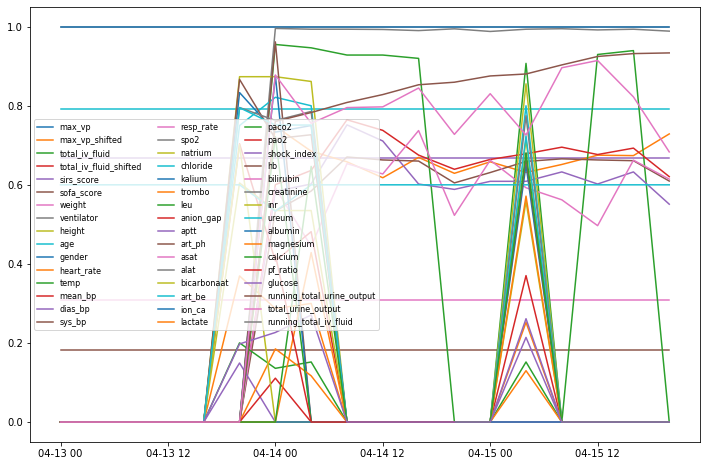

In [120]:
import matplotlib.pyplot as plt

# Limit plot to one ICU stay
icustay_id = random.choice(list(set(data_train_df['icustay_id'])))
icustay_df = data_train_df[data_train_df['icustay_id'] == icustay_id]

# Plot interesting columns
plt.figure(figsize=(12, 8))
for col in icustay_df.columns:
    if col not in EXCLUDE:
        plt.plot(icustay_df['timestep'], icustay_df[col], label=col)
        
plt.legend(ncol=3, prop={'size': 8})
plt.show()